In [1]:
'''
In this notebook we train our model. The thickness and number of hidden layers were tuned manually, 
but otherwise nothing else has. Once could e.g. change the activation function from tanh to relu.

The FunctionScalar package (https://github.com/weissercn/FunctionScaler/) is used to preprocess the data. 
Installing this package can be done using pip (pip install FunctionScaler)
'''

'\nIn this notebook we train our model. The thickness and number of hidden layers were tuned manually, \nbut otherwise nothing else has. Once could e.g. change the activation function from tanh to relu.\n\nThe FunctionScalar package (https://github.com/weissercn/FunctionScaler/) is used to preprocess the data. \nInstalling this package can be done using pip (pip install FunctionScaler)\n'

In [15]:
# Importing necessary libraries
import math
import string
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from __future__ import print_function
from sklearn import metrics
from sklearn.model_selection import train_test_split


plt.rc('text', usetex=False)
%matplotlib inline

In [3]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '1'

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)

from Autoencoder_Utils import *

/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Loading the data
TYPE = "" # 100% of the data. To determine the real performance of the cross check
# TYPE = "_10perc" # 10% of the data. Used for everything except to determine the real performance of the cross check
# TYPE = "_1perc" # 1% of the data. For small tests.
# TYPE = "_100" # 100 samples of the data. For very rudimentary tests


df = pd.read_csv('Data/Df_example{}.csv'.format(TYPE))
var_list = list(df)

In [5]:
# How many samples of each particle do we have
print(df['pid'].value_counts())
pids_no = df['pid'].value_counts().to_dict()
n_samples = np.shape(df.as_matrix())[0]

f    454948
e    450775
a    438012
c    408195
d    377725
b    358002
Name: pid, dtype: int64


In [6]:
# Dividing the variables into compressable, auxiliary and simulation truth variables not seen in real datasets
vars_list = list(df)
vars_list_input, vars_list_aux, vars_list_MC = [], [], [] 
for v in vars_list:
    if v == 'pid': 
        vars_list_MC.append(v)
    elif 'aux' in v: 
        vars_list_aux.append(v)
    else: 
        vars_list_input.append(v)
print("{} variables to compress".format(len(vars_list_input)))

18 variables to compress


CPU times: user 10.4 s, sys: 4.07 s, total: 14.4 s
Wall time: 9.32 s


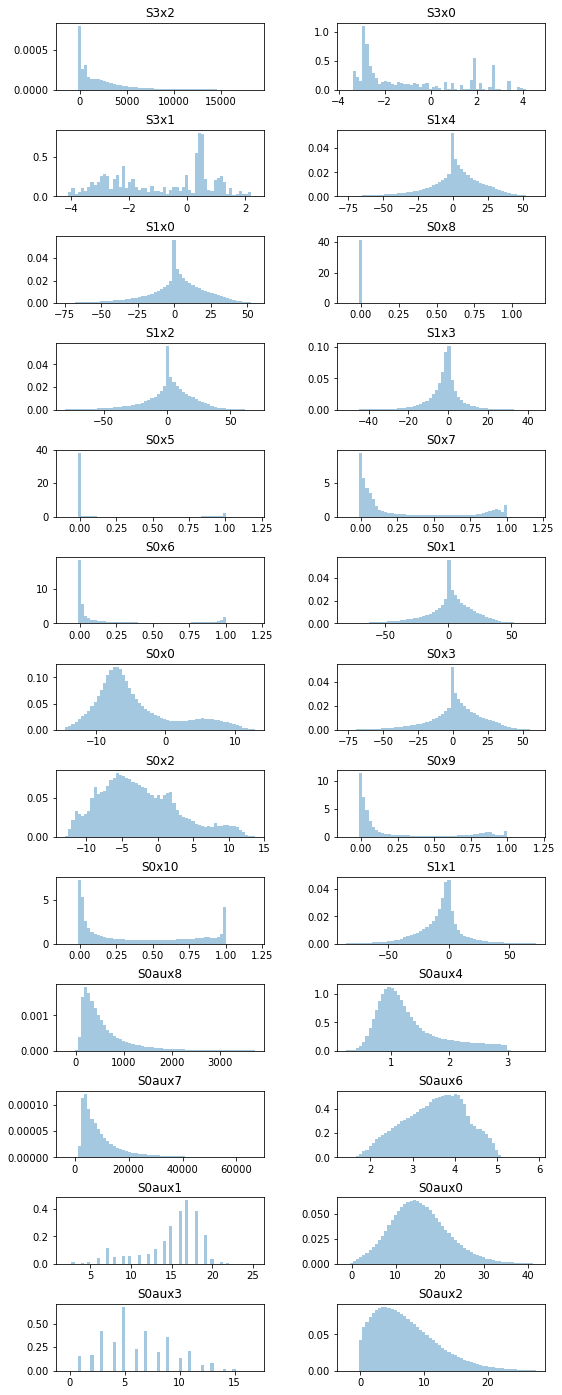

In [7]:
%%time
# Display histograms of our features
print_features_histograms(df[vars_list_input + vars_list_aux], None, save_filename="./img/original_distribs.png")

 S C A L E D --- D F 
CPU times: user 8min 31s, sys: 20.8 s, total: 8min 52s
Wall time: 8min 42s


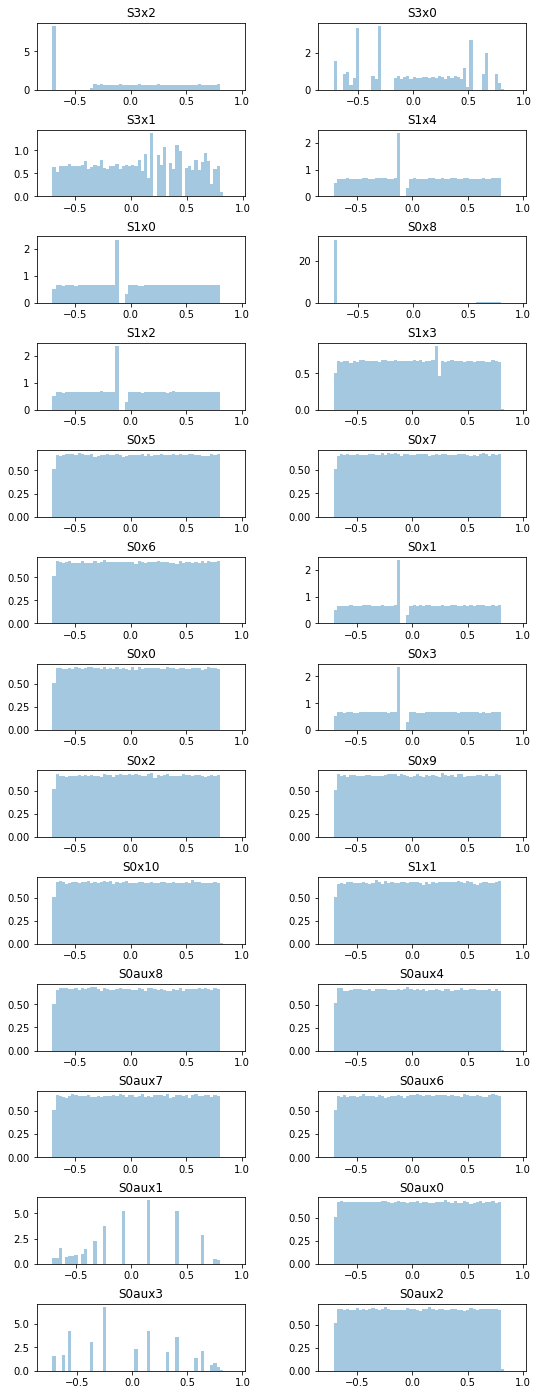

In [10]:
%%time
##############################
#####   S C A L I N G  #######
##############################

# We want to scale. The output of the decoder will be between -1 and 1 due to the chosen activation function. 
# Hence, all features should be scaled to range between -1 and 1
# We use percentile scaling. Maybe other methods are more optimal

SCALING           = True
SCALE_BY_CORR_PID = False


if SCALING:
    if SCALE_BY_CORR_PID:
        # Mike suggested that the ProbNN-mu variable is only scaled by the distribution of 
        # ProbNNmu for the corresponding particle (muon).
        # This way the mean squared error for low values of ProbNNmu doesn't matter as much. 

        # This is not implemented for AUX variables, yet
        scaling_ar = np.zeros((pids_no[fig_to_corr_pid[0]], 1))

        for i_pid, pid in enumerate(fig_to_corr_pid):
            scaling_ar_temp = df.loc[df['pid'] == pid][[var_list[i_pid + 1]]]
#             scaling_ar_temp = df[[var_list[i_pid]]]
            scaling_ar_temp = scaling_ar_temp.values
#             print(type(scaling_df_temp))
#             print(scaling_df_temp)
            scaling_ar = np.c_[scaling_ar, scaling_ar_temp]
#         print(scaling_ar)
        scaling_df = pd.DataFrame(scaling_ar, columns=df.columns)
        
        print (" S C A L I N G --- D F ")
        print_features_histograms(df, scaling_df, save_filename="./img/unscaled_distribs.png", normed=False)
        
        print ("--"*100)


    data_MC    = df[vars_list_MC].copy().values
    data_input = df[vars_list_input].copy().values
    data_aux   = df[vars_list_aux].copy().values
    

    # Scaling, so that output is uniform. I wrote this package
    import sys
    sys.path.append('./FunctionScaler/FunctionScaler/')
    import FunctionScaler
    fs = FunctionScaler.FunctionScaler(
        FunctionScaler.TransformedFunction_Uniform(-0.7, 0.8), 
        downplay_outofbounds_lower_n_range=None, 
        downplay_outofbounds_upper_n_range=None, 
        downplay_outofbounds_lower_set_point=None, 
        downplay_outofbounds_upper_set_point= None
    ) # calling the normal function by name
    fs_aux = FunctionScaler.FunctionScaler(
        FunctionScaler.TransformedFunction_Uniform(-0.7, 0.8), 
        downplay_outofbounds_lower_n_range=None, 
        downplay_outofbounds_upper_n_range=None, 
        downplay_outofbounds_lower_set_point=None, 
        downplay_outofbounds_upper_set_point= None
    ) # calling the normal function by name
    
    if SCALE_BY_CORR_PID: 
        fs.fit(scaling_df.values[:, 1:])
    else                : 
#         fs.fit(df.values[:, 1:])
        if "prec" in TYPE:
            fs.fit(data_input)
            fs_aux.fit(data_aux)
        else:
            # It takes a long time to fit the scaling. 
            # We don't need a superprecise scaling, so use only 10% of the data
            fs.fit(data_input[:int(len(data_input)/10), :]) # Train the transform on 10% of the data
            fs_aux.fit(data_aux[:int(len(data_aux)/10), :]) # Train the transform on 10% of the data
        
    scaled_data_input = fs.transform(data_input)
    scaled_data_aux = fs_aux.transform(data_aux)

    if SCALE_BY_CORR_PID: 
        scaled_scaling_features = fs.transform(scaling_df.values[:, 1:])
        scaled_scaling_features = np.c_[scaling_df.values[:,0], scaled_scaling_features]
        scaled_scaling_features_df = pd.DataFrame(scaled_scaling_features, columns=scaling_df.columns)

    scaled_features = np.c_[data_MC,scaled_data_input, scaled_data_aux]
    scaled_features_df = pd.DataFrame(
        scaled_features, index=df.index, columns=vars_list_MC + vars_list_input + vars_list_aux
    )
    scaled_features_df.head()
    
    print (" S C A L E D --- D F ")
    
    # Display histograms of scaled features
    if SCALE_BY_CORR_PID:
        print_features_histograms(
            scaled_features_df[vars_list_input + vars_list_aux], 
            scaled_scaling_features_df[vars_list_input + vars_list_aux], 
            save_filename="./img/scaled_distribs.png", normed=False
        )
    else:
        print_features_histograms(
            scaled_features_df[vars_list_input + vars_list_aux], None, 
            save_filename="./img/scaled_distribs.png", normed=True
        )
    
    df = scaled_features_df

In [11]:
# Dividing into Training, Testing and Validation samples
training_frac = 0.70
val_frac      = 0.20


n_train = int(n_samples*training_frac)
n_val = int(n_samples*val_frac) 
n_test = int(n_samples*(1-training_frac-val_frac))

print ("Nb train exmaples " + str(n_train) )
print ("Nb val exmaples " + str(n_val) )
print ("Nb test exmaples " + str(n_test) )

Nb train exmaples 1741359
Nb val exmaples 497531
Nb test exmaples 248765


In [12]:
# Do the training 
l_encoding_dim = [1, 3, 6, 9, 12, 15, 18]

if "dummy" in TYPE: 
    l_encoding_dim = [9]

l_score = []

# n_layers = 3; thickness = 2 # Unopt
n_layers = 4; thickness = 6 # Manually optimised. However, architecture should be optimised


name_arch = "{}h_nodrop_aux".format(n_layers)
train, test = train_test_split(df, random_state=42, train_size=training_frac + val_frac)
        
train_input = train[vars_list_input].copy().values
train_aux   = train[vars_list_aux].copy().values
train_MC    = train[vars_list_MC].copy().values

test_input = test[vars_list_input].copy().values
test_aux   = test[vars_list_aux].copy().values
test_MC    = test[vars_list_MC].copy().values


if train_aux.shape[1] == 0: 
    train_aux = np.ones((train_input.shape[0], 2))
    
if test_aux.shape[1] == 0: 
    test_aux = np.ones((test_input.shape[0], 2))
    
print(train_input.shape, train_aux.shape, train_MC.shape)
print(test_input.shape, test_aux.shape, test_MC.shape)

(2238891, 18) (2238891, 8) (2238891, 1)
(248766, 18) (248766, 8) (248766, 1)


  0%|          | 0/7 [00:00<?, ?it/s]

encoding_dim :  1
Train on 1741359 samples, validate on 497532 samples
Epoch 1/50
1741359/1741359 [==============================] - 311s 178us/step - loss: 0.0493 - val_loss: 0.0423
Epoch 2/50
1741359/1741359 [==============================] - 308s 177us/step - loss: 0.0398 - val_loss: 0.0372
Epoch 3/50
1741359/1741359 [==============================] - 308s 177us/step - loss: 0.0365 - val_loss: 0.0361
Epoch 4/50
1741359/1741359 [==============================] - 308s 177us/step - loss: 0.0492 - val_loss: 0.0529
Epoch 5/50
1741359/1741359 [==============================] - 306s 176us/step - loss: 0.0478 - val_loss: 0.0560
Epoch 6/50
1741359/1741359 [==============================] - 309s 178us/step - loss: 0.0465 - val_loss: 0.0440
Epoch 7/50
1741359/1741359 [==============================] - 308s 177us/step - loss: 0.0442 - val_loss: 0.0452
Epoch 8/50
1741359/1741359 [==============================] - 309s 177us/step - loss: 0.0439 - val_loss: 0.0402
Epoch 00008: early stopping
24876

 14%|█▍        | 1/7 [41:29<4:08:54, 2489.14s/it]




encoding_dim :  3
Train on 1741359 samples, validate on 497532 samples
Epoch 1/50
1741359/1741359 [==============================] - 312s 179us/step - loss: 0.0158 - val_loss: 0.0117
Epoch 2/50
1741359/1741359 [==============================] - 312s 179us/step - loss: 0.0110 - val_loss: 0.0099
Epoch 3/50
1741359/1741359 [==============================] - 312s 179us/step - loss: 0.0100 - val_loss: 0.0100
Epoch 4/50
1741359/1741359 [==============================] - 311s 179us/step - loss: 0.0098 - val_loss: 0.0117
Epoch 5/50
1741359/1741359 [==============================] - 315s 181us/step - loss: 0.0095 - val_loss: 0.0099
Epoch 6/50
1741359/1741359 [==============================] - 313s 180us/step - loss: 0.0093 - val_loss: 0.0089
Epoch 7/50
1741359/1741359 [==============================] - 311s 179us/step - loss: 0.0101 - val_loss: 0.0123
Epoch 8/50
1741359/1741359 [==============================] - 314s 180us/step - loss: 0.0106 - val_loss: 0.0100
Epoch 9/50
1741359/1741359 [==

 29%|██▊       | 2/7 [1:39:11<3:51:45, 2781.14s/it]




encoding_dim :  6
Train on 1741359 samples, validate on 497532 samples
Epoch 1/50
1741359/1741359 [==============================] - 316s 182us/step - loss: 0.0048 - val_loss: 0.0034
Epoch 2/50
1741359/1741359 [==============================] - 313s 180us/step - loss: 0.0030 - val_loss: 0.0027
Epoch 3/50
1741359/1741359 [==============================] - 311s 178us/step - loss: 0.0027 - val_loss: 0.0025
Epoch 4/50
1741359/1741359 [==============================] - 312s 179us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 5/50
1741359/1741359 [==============================] - 312s 179us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/50
1741359/1741359 [==============================] - 312s 179us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/50
1741359/1741359 [==============================] - 310s 178us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/50
1741359/1741359 [==============================] - 311s 178us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/50
1741359/1741359 [==

 43%|████▎     | 3/7 [2:52:33<3:37:49, 3267.42s/it]




encoding_dim :  9
Train on 1741359 samples, validate on 497532 samples
Epoch 1/50
1741359/1741359 [==============================] - 315s 181us/step - loss: 0.0025 - val_loss: 0.0015
Epoch 2/50
1741359/1741359 [==============================] - 316s 181us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 3/50
1741359/1741359 [==============================] - 315s 181us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/50
1741359/1741359 [==============================] - 316s 181us/step - loss: 9.9785e-04 - val_loss: 9.3875e-04
Epoch 5/50
1741359/1741359 [==============================] - 318s 183us/step - loss: 9.2334e-04 - val_loss: 8.5277e-04
Epoch 6/50
1741359/1741359 [==============================] - 314s 180us/step - loss: 8.5963e-04 - val_loss: 8.3140e-04
Epoch 7/50
1741359/1741359 [==============================] - 312s 179us/step - loss: 8.2661e-04 - val_loss: 8.4045e-04
Epoch 8/50
1741359/1741359 [==============================] - 315s 181us/step - loss: 7.8893e-04 - val_loss: 7

 57%|█████▋    | 4/7 [5:35:59<4:21:26, 5228.99s/it]




encoding_dim :  12
Train on 1741359 samples, validate on 497532 samples
Epoch 1/50
1741359/1741359 [==============================] - 314s 180us/step - loss: 0.0014 - val_loss: 9.0254e-04
Epoch 2/50
1741359/1741359 [==============================] - 331s 190us/step - loss: 5.8519e-04 - val_loss: 6.8309e-04
Epoch 3/50
1741359/1741359 [==============================] - 326s 187us/step - loss: 4.8830e-04 - val_loss: 4.4436e-04
Epoch 4/50
1741359/1741359 [==============================] - 316s 182us/step - loss: 4.3198e-04 - val_loss: 4.1140e-04
Epoch 5/50
1741359/1741359 [==============================] - 314s 180us/step - loss: 4.2795e-04 - val_loss: 4.6960e-04
Epoch 6/50
1741359/1741359 [==============================] - 314s 180us/step - loss: 4.1964e-04 - val_loss: 3.3292e-04
Epoch 7/50
1741359/1741359 [==============================] - 316s 182us/step - loss: 3.7272e-04 - val_loss: 4.0247e-04
Epoch 8/50
1741359/1741359 [==============================] - 323s 185us/step - loss: 3.7

 71%|███████▏  | 5/7 [6:35:01<2:37:25, 4722.92s/it]




encoding_dim :  15
Train on 1741359 samples, validate on 497532 samples
Epoch 1/50
1741359/1741359 [==============================] - 330s 190us/step - loss: 9.0788e-04 - val_loss: 4.3700e-04
Epoch 2/50
1741359/1741359 [==============================] - 321s 184us/step - loss: 3.5031e-04 - val_loss: 2.0384e-04
Epoch 3/50
1741359/1741359 [==============================] - 317s 182us/step - loss: 2.6326e-04 - val_loss: 2.2935e-04
Epoch 4/50
1741359/1741359 [==============================] - 315s 181us/step - loss: 2.4745e-04 - val_loss: 1.4792e-04
Epoch 5/50
1741359/1741359 [==============================] - 317s 182us/step - loss: 2.1572e-04 - val_loss: 1.6307e-04
Epoch 6/50
1741359/1741359 [==============================] - 318s 183us/step - loss: 2.0390e-04 - val_loss: 1.6206e-04
Epoch 7/50
1741359/1741359 [==============================] - 316s 182us/step - loss: 1.7598e-04 - val_loss: 1.4784e-04
Epoch 8/50
1741359/1741359 [==============================] - 318s 182us/step - loss:

 86%|████████▌ | 6/7 [7:40:15<1:14:40, 4480.27s/it]




encoding_dim :  18
Train on 1741359 samples, validate on 497532 samples
Epoch 1/50
1741359/1741359 [==============================] - 321s 184us/step - loss: 7.4455e-04 - val_loss: 4.6931e-04
Epoch 2/50
1741359/1741359 [==============================] - 332s 190us/step - loss: 2.9247e-04 - val_loss: 2.6055e-04
Epoch 3/50
1741359/1741359 [==============================] - 330s 190us/step - loss: 2.3658e-04 - val_loss: 2.5265e-04
Epoch 4/50
1741359/1741359 [==============================] - 338s 194us/step - loss: 2.0628e-04 - val_loss: 1.6047e-04
Epoch 5/50
1741359/1741359 [==============================] - 315s 181us/step - loss: 1.7918e-04 - val_loss: 1.7770e-04
Epoch 6/50
1741359/1741359 [==============================] - 314s 180us/step - loss: 1.6656e-04 - val_loss: 1.3686e-04
Epoch 7/50
1741359/1741359 [==============================] - 315s 181us/step - loss: 1.5921e-04 - val_loss: 1.7121e-04
Epoch 8/50
1741359/1741359 [==============================] - 315s 181us/step - loss:

100%|██████████| 7/7 [9:47:44<00:00, 5430.70s/it]  




CPU times: user 12h 3min 29s, sys: 2h 28min 6s, total: 14h 31min 35s
Wall time: 9h 47min 58s


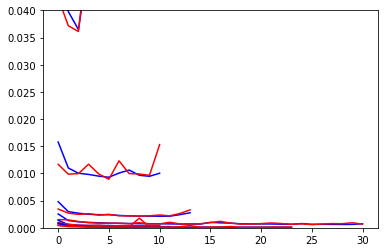

In [16]:
%%time
nb_epoch = 50
batch_size = 50

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=3, mode='min')
tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True) # you can try to run this visualization

save_decoded_dict = {}
save_encoded_dict = {}
    
for encoding_dim in tqdm(l_encoding_dim):
    print("encoding_dim : ", encoding_dim)

    autoencoder, encoder, decoder = create_autoencoder_aux(
        train_input.shape[1], encoding_dim, 
        n_aux_features=train_aux.shape[1], n_layers=n_layers, thickness=thickness
    )

    history = autoencoder.fit(
        [train_input, train_aux], train_input,
        epochs=nb_epoch, batch_size=batch_size,
        shuffle=True, verbose=1,
        validation_split=val_frac/(training_frac + val_frac), callbacks =[early_stopping, tensorboard]
    )

    score = autoencoder.evaluate([test_input, test_aux], test_input, batch_size=batch_size)
    # print ("\n\nscore : ", score)
    l_score.append(score)

    encoded_test = encoder.predict([test_input, test_aux])
    decoded_test = decoder([encoded_test, test_aux, 0])[0] # test mode = 0
#     print_features_histograms(pd.DataFrame(decoded_test), target=pd.DataFrame(test_input))

    save_decoded_dict[encoding_dim] = decoded_test.astype(np.float64)
    save_encoded_dict[encoding_dim] = encoded_test.astype(np.float64)

#     plt.clf()
    plt.plot(history.history['loss'], "b")
    plt.plot(history.history['val_loss'], "r")
    plt.ylim(0, 0.04)
#     plt.xlim(0, 40)
    print("\n\n")

In [17]:
# Save what you want to retain to this dictionary
retain_dict = {}
retain_dict['save_decoded_dict'] = save_decoded_dict
retain_dict['save_encoded_dict'] = save_encoded_dict
retain_dict['test_input'] = test_input.astype(np.float64)
retain_dict['test_aux'] = test_aux.astype(np.float64)
retain_dict['test_MC'] = test_MC
retain_dict['l_score'] = l_score
retain_dict['vars_list_input'] = vars_list_input

In [18]:
retain_dict['test_input_dec'] = fs.invtransform(test_input.astype(np.float64))
retain_dict['test_aux_dec'] = fs_aux.invtransform(test_aux.astype(np.float64))

save_decoded_dict_dec = {}
for encoding_dim in save_decoded_dict:
    save_decoded_dict_dec[encoding_dim] = fs.invtransform(save_decoded_dict[encoding_dim].astype(np.float64))

retain_dict['save_decoded_dict_dec'] = save_decoded_dict_dec

In [19]:
pickle.dump(retain_dict, open("retain_dict_{}.p".format(TYPE), "wb"))

In [20]:
# Visualise the model part I
from keras.utils import plot_model

plot_model(autoencoder, to_file='./img/model.png')

InvocationException: Program terminated with status: 1. stderr follows: Warning: Could not load "/opt/conda/anaconda3/lib/graphviz/libgvplugin_pango.so.6" - file not found
Warning: Could not load "/opt/conda/anaconda3/lib/graphviz/libgvplugin_pango.so.6" - file not found
Format: "png" not recognized. Use one of: canon cmap cmapx cmapx_np dot eps fig gv imap imap_np ismap pdf pic plain plain-ext png pov ps ps2 svg svgz tk vml vmlz xdot xdot1.2 xdot1.4


In [23]:
# Visualise the model part II
from keras.utils.vis_utils import plot_model

plot_model(autoencoder, to_file='./img/model_plot.png', show_shapes=True, show_layer_names=False)

InvocationException: Program terminated with status: 1. stderr follows: Warning: Could not load "/opt/conda/anaconda3/lib/graphviz/libgvplugin_pango.so.6" - file not found
Warning: Could not load "/opt/conda/anaconda3/lib/graphviz/libgvplugin_pango.so.6" - file not found
Format: "png" not recognized. Use one of: canon cmap cmapx cmapx_np dot eps fig gv imap imap_np ismap pdf pic plain plain-ext png pov ps ps2 svg svgz tk vml vmlz xdot xdot1.2 xdot1.4
